In [1]:
# Install required packages
!pip install ultralytics easyocr opencv-python matplotlib pillow -q

# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
from ultralytics import YOLO
from typing import List, Tuple, Dict, Any
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(" All required packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 21.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
 All required packages imported successfully!


# Load the Trained YOLOv8 Model

In [2]:
# Load the trained YOLOv8 model
def load_model(model_path: str = "best.pt"):
    """
    Load the trained YOLOv8 model from the specified path.

    Args:
        model_path (str): Path to the trained model file (best.pt)

    Returns:
        YOLO: Loaded YOLOv8 model
    """
    try:
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at: {model_path}")

        model = YOLO(model_path)
        print(f" Model loaded successfully from: {model_path}")
        print(f" Model architecture: {model.overrides['task']}")
        return model
    except Exception as e:
        print(f" Error loading model: {e}")
        return None

# Load the model
model = load_model("/content/best.pt")

 Model loaded successfully from: /content/best.pt
 Model architecture: detect


# Initialize the OCR Reader

In [4]:
# Initialize the OCR reader
def initialize_ocr(languages: List[str] = ['en']):
    """
    Initialize the EasyOCR reader with specified languages.

    Args:
        languages (List[str]): List of languages to recognize

    Returns:
        easyocr.Reader: Initialized OCR reader
    """
    try:
        reader = easyocr.Reader(languages, gpu=False)  # Set gpu=True if you have CUDA
        print(f" OCR reader initialized successfully for languages: {languages}")
        return reader
    except Exception as e:
        print(f" Error initializing OCR reader: {e}")
        return None

# Initialize OCR reader
ocr_reader = initialize_ocr(['en'])

 OCR reader initialized successfully for languages: ['en']


# Create Drug Detection and OCR Pipeline

In [6]:
# Function to detect drug names using YOLOv8
def detect_drug_names(
    model,
    image_path: str,
    confidence_threshold: float = 0.5
) -> Tuple[np.ndarray, List[Dict[str, Any]]]:
    """
    Detect drug names in an image using the trained YOLOv8 model.

    Args:
        model: Loaded YOLOv8 model
        image_path (str): Path to the input image
        confidence_threshold (float): Minimum confidence score for detection

    Returns:
        Tuple: (image array, list of detection results)
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from: {image_path}")

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run inference
    results = model(image_rgb, conf=confidence_threshold, verbose=False)

    # Extract detection information
    detections = []
    for result in results:
        if result.boxes is not None:
            for box in result.boxes:
                detection = {
                    'bbox': box.xyxy[0].cpu().numpy(),  # [x1, y1, x2, y2]
                    'confidence': box.conf[0].cpu().numpy(),
                    'class_id': int(box.cls[0].cpu().numpy())
                }
                detections.append(detection)

    return image_rgb, detections

# Function to crop detected regions from image
def crop_detected_regions(
    image: np.ndarray,
    detections: List[Dict[str, Any]],
    padding: int = 5
) -> List[np.ndarray]:
    """
    Crop the detected regions from the image with optional padding.

    Args:
        image (np.ndarray): Input image
        detections (List[Dict]): List of detection results
        padding (int): Padding around the detection in pixels

    Returns:
        List[np.ndarray]: List of cropped image regions
    """
    cropped_regions = []
    height, width = image.shape[:2]

    for detection in detections:
        x1, y1, x2, y2 = detection['bbox']

        # Add padding and ensure within image bounds
        x1 = max(0, int(x1) - padding)
        y1 = max(0, int(y1) - padding)
        x2 = min(width, int(x2) + padding)
        y2 = min(height, int(y2) + padding)

        # Crop the region
        cropped_region = image[y1:y2, x1:x2]
        cropped_regions.append(cropped_region)

    return cropped_regions

# Function to perform OCR on cropped regions
def extract_text_from_regions(
    reader,
    cropped_regions: List[np.ndarray],
    detection_confidences: List[float]
) -> List[Dict[str, Any]]:
    """
    Extract text from cropped regions using OCR.

    Args:
        reader: Initialized OCR reader
        cropped_regions (List[np.ndarray]): List of cropped image regions
        detection_confidences (List[float]): Confidence scores for each detection

    Returns:
        List[Dict]: List of text extraction results with confidence scores
    """
    text_results = []

    for i, region in enumerate(cropped_regions):
        # Convert RGB to BGR for EasyOCR (if needed)
        if len(region.shape) == 3 and region.shape[2] == 3:
            region_bgr = cv2.cvtColor(region, cv2.COLOR_RGB2BGR)
        else:
            region_bgr = region

        # Perform OCR
        ocr_results = reader.readtext(region_bgr)

        # Combine all detected text
        combined_text = " ".join([result[1] for result in ocr_results])

        # Calculate average confidence (weighted by text length)
        if ocr_results:
            total_chars = sum(len(result[1]) for result in ocr_results)
            avg_confidence = sum(len(result[1]) * result[2] for result in ocr_results) / total_chars
        else:
            avg_confidence = 0.0

        text_results.append({
            'text': combined_text,
            'ocr_confidence': avg_confidence,
            'detection_confidence': detection_confidences[i],
            'overall_confidence': (avg_confidence + detection_confidences[i]) / 2
        })

    return text_results

# Complete pipeline function
def drug_name_detection_pipeline(
    model,
    reader,
    image_path: str,
    confidence_threshold: float = 0.5,
    padding: int = 5
) -> Dict[str, Any]:
    """
    Complete pipeline for drug name detection and text extraction.

    Args:
        model: Loaded YOLOv8 model
        reader: Initialized OCR reader
        image_path (str): Path to the input image
        confidence_threshold (float): Detection confidence threshold
        padding (int): Padding around detections

    Returns:
        Dict: Complete results including image, detections, and extracted text
    """
    start_time = time.time()

    # Step 1: Detect drug names
    image, detections = detect_drug_names(model, image_path, confidence_threshold)
    detection_time = time.time()

    # Step 2: Crop detected regions
    cropped_regions = crop_detected_regions(image, detections, padding)
    cropping_time = time.time()

    # Step 3: Extract text from cropped regions
    detection_confidences = [detection['confidence'] for detection in detections]
    text_results = extract_text_from_regions(reader, cropped_regions, detection_confidences)
    ocr_time = time.time()

    # Prepare results
    results = {
        'image': image,
        'detections': detections,
        'cropped_regions': cropped_regions,
        'text_results': text_results,
        'timing': {
            'detection': detection_time - start_time,
            'cropping': cropping_time - detection_time,
            'ocr': ocr_time - cropping_time,
            'total': ocr_time - start_time
        }
    }

    return results

# Visualization Functions

In [8]:
# Function to visualize results
def visualize_results(results: Dict[str, Any], save_path: str = None):
    """
    Visualize the drug name detection and OCR results.

    Args:
        results (Dict): Results from the pipeline
        save_path (str): Path to save the visualization (optional)
    """
    image = results['image']
    detections = results['detections']
    text_results = results['text_results']

    # Create a copy for drawing
    image_with_boxes = image.copy()

    # Draw bounding boxes and labels
    for i, detection in enumerate(detections):
        x1, y1, x2, y2 = detection['bbox']
        confidence = detection['confidence']

        # Draw bounding box
        cv2.rectangle(image_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

        # Prepare label text
        if i < len(text_results):
            text = text_results[i]['text']
            label = f"{text} ({confidence:.2f})"
        else:
            label = f"Detection ({confidence:.2f})"

        # Draw label background
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image_with_boxes,
                     (int(x1), int(y1) - label_size[1] - 10),
                     (int(x1) + label_size[0], int(y1)),
                     (0, 255, 0), -1)

        # Draw label text
        cv2.putText(image_with_boxes, label, (int(x1), int(y1) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Show original image with detections
    axes[0].imshow(image_with_boxes)
    axes[0].set_title('Drug Name Detections')
    axes[0].axis('off')

    # Show cropped regions if any
    if results['cropped_regions']:
        # Create a grid of cropped regions
        n_cropped = len(results['cropped_regions'])
        if n_cropped > 0:
            # For single cropped region
            if n_cropped == 1:
                axes[1].imshow(results['cropped_regions'][0])
                axes[1].set_title('Cropped Region')
                axes[1].axis('off')
            else:
                # For multiple cropped regions, create a grid
                n_cols = min(3, n_cropped)
                n_rows = (n_cropped + n_cols - 1) // n_cols

                # Clear the second axis
                axes[1].remove()

                # Create subgrid for cropped regions
                subfig = fig.add_subplot(1, 2, 2)
                subfig.set_title('Cropped Regions')

                for i, cropped in enumerate(results['cropped_regions']):
                    plt.subplot(n_rows, n_cols, i+1)
                    plt.imshow(cropped)
                    plt.title(f'Region {i+1}')
                    plt.axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No regions detected',
                    horizontalalignment='center', verticalalignment='center',
                    transform=axes[1].transAxes, fontsize=12)
        axes[1].axis('off')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

    # Print text results
    print(" Text Extraction Results:")
    print("=" * 50)
    for i, result in enumerate(text_results):
        print(f"Region {i+1}:")
        print(f"  Text: '{result['text']}'")
        print(f"  OCR Confidence: {result['ocr_confidence']:.3f}")
        print(f"  Detection Confidence: {result['detection_confidence']:.3f}")
        print(f"  Overall Confidence: {result['overall_confidence']:.3f}")
        print()

    # Print timing information
    print(" Processing Times:")
    print(f"  Detection: {results['timing']['detection']:.3f}s")
    print(f"  Cropping: {results['timing']['cropping']:.3f}s")
    print(f"  OCR: {results['timing']['ocr']:.3f}s")
    print(f"  Total: {results['timing']['total']:.3f}s")

# Process Single Image

 Processing image: allopurinol_jpeg_jpg.rf.1e7136d8d3b5320a44a614712fd722d1.jpg


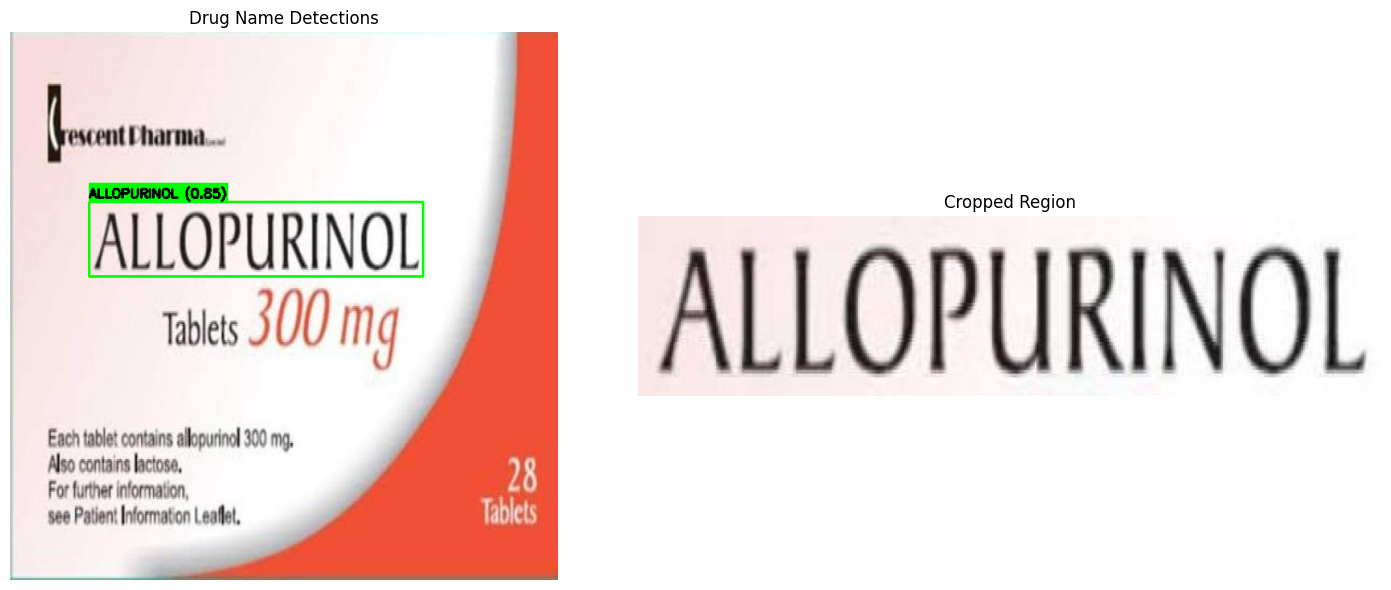

 Text Extraction Results:
Region 1:
  Text: 'ALLOPURINOL'
  OCR Confidence: 0.711
  Detection Confidence: 0.846
  Overall Confidence: 0.778

 Processing Times:
  Detection: 0.025s
  Cropping: 0.000s
  OCR: 0.400s
  Total: 0.425s


In [20]:
# Process a single image
def process_single_image(
    image_path: str,
    confidence_threshold: float = 0.5,
    save_visualization: bool = False
):
    """
    Process a single image through the complete pipeline.

    Args:
        image_path (str): Path to the input image
        confidence_threshold (float): Detection confidence threshold
        save_visualization (bool): Whether to save the visualization
    """
    if not os.path.exists(image_path):
        print(f" Image not found: {image_path}")
        return None

    print(f" Processing image: {os.path.basename(image_path)}")
    print("=" * 50)

    # Run the complete pipeline
    results = drug_name_detection_pipeline(
        model, ocr_reader, image_path, confidence_threshold
    )

    # Visualize results
    if save_visualization:
        save_path = f"results_{os.path.basename(image_path)}"
        visualize_results(results, save_path)
    else:
        visualize_results(results)

    return results

# Test with a sample image (replace with your image path)
sample_image_path = "/content/allopurinol_jpeg_jpg.rf.1e7136d8d3b5320a44a614712fd722d1.jpg"

# Check if sample image exists, if not, create a dummy example
if not os.path.exists(sample_image_path):
    print(" Sample image not found. Please set the correct path to your image.")
else:
    results = process_single_image(sample_image_path, confidence_threshold=0.5, save_visualization=True)